In [163]:
import numpy as np
from cnns.core import DBSCANClusterer as dbcl
import matplotlib.pyplot as plt
import matplotlib
import pickle as pkl
from scipy.spatial.distance import pdist
import pandas as pd
from sklearn.metrics.cluster import homogeneity_completeness_v_measure
from sklearn.metrics.pairwise import pairwise_distances

In [182]:
%matplotlib inline
plt.style.use('bmh')
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
dist_matrix

In [183]:
def plot_k_nearest_dist(X, k=[2, 3, 4, 5, 6]):
    _, ax = plt.subplots()
    for k_ in k:
        k_nearest_dists = [None]*X.shape[0]
        dist_matrix = pairwise_distances(X)
        for idx, dist in enumerate(dist_matrix):
            k_nearest_dists[idx] = np.sort(dist)[k_+1]
        sorted_k_nearest_dists = np.sort(k_nearest_dists)
        ax.plot(range(len(sorted_k_nearest_dists)), sorted_k_nearest_dists)
    
    ax.set_title('Sorted nearest neighbor distances')
    ax.set_xlabel('Points')
    ax.set_ylabel('Pairwise euclidean distance')
    plt.draw()

def load_data(user_id):
    cnn_codes_dirpath = '/Users/babasarala/Desktop/face_clustering/openface_experiments'
    cnn_codes_pklpath = '%s/%i_cnn_codes.p'%(cnn_codes_dirpath, user_id)
    img_urls, X = pkl.load(open(cnn_codes_pklpath, 'rb'))
    return img_urls, X

def run_dbscan_and_plot(user_id, eps_list=None):
    csv_filepath = '/Users/babasarala/Desktop/face_clustering_full_data/%i/%i_prod_fb_tags_img_urls_1.2_None.csv' \
    %(user_id, user_id)
    ground_truth_csv_filepath = '/Users/babasarala/Desktop/face_clustering_full_data/%i_clusters.csv'%user_id
    img_urls, X = load_data(user_id)
    inner_dists = pdist(X, 'euclidean')
    
    if eps_list is None:
        q1 = np.percentile(inner_dists, q=0.025)
        q2 = np.percentile(inner_dists, q=99.5)
        eps_list = list(np.linspace(q1, q2, ))
    
    _, ax = plt.subplots()
    ax.set_title('Histogram of inner-face distances')
    ax.hist(inner_dists, bins=30)
    
    _, axs = plt.subplots(2,2)
    ax_1 = axs[0][0]
    ax_2 = axs[0][1]
    ax_3 = axs[1][0]
    ax_4 = axs[1][1]
    perc_noisy_samples = []
    hs = []
    cs = []
    vs = []
    for eps in eps_list:
        dbcl_ = dbcl.DBSCANClusterer(eps=eps, min_samples=3)
        dbcl_.load_data(img_urls, X)
        cluster_df = dbcl_.run()
        perc_noisy_samples.append(1.*dbcl_.num_noisy_samples/len(img_urls))

        # compute H, C, V
        url_df = pd.read_csv(open(csv_filepath, 'rb'))
        tagged_df = pd.read_csv(open(ground_truth_csv_filepath, 'rb'))
        gt_df = pd.merge(cluster_df, url_df, left_on='face_url', right_on='img_url')
        cols = ['face_id', 'tag', 'memorable_id', 'cluster_idx', 'face_url']
        merged_df = pd.merge(
            gt_df, tagged_df, on=['face_id', 'memorable_id', 'user_id'])[cols]
        true_labels = list(merged_df['tag'].values)
        cluster_labels = list(merged_df['cluster_idx'].values)
        h, c, v = homogeneity_completeness_v_measure(true_labels, cluster_labels)
        hs.append(h)
        cs.append(c)
        vs.append(v)

    stats_df = pd.DataFrame({'eps': eps_list,
                             'perc_noisy_samples':perc_noisy_samples,
                             'homogeneity': hs, 
                             'completeness': cs, 
                             'V-measure': vs})
    
    ax_1.plot(eps_list, perc_noisy_samples)
    ax_1.set_xlabel('eps')
    ax_1.set_ylabel('perc_noisy_samples')
    ax_1.set_title('Percentage of noisy samples vs. EPS')
    
    
    ax_2.plot(eps_list, hs)
    ax_2.set_xlabel('eps')
    ax_2.set_ylabel('homogeneity')
    ax_2.set_title('Homogeneity vs. EPS')

    ax_3.plot(eps_list, cs)
    ax_3.set_xlabel('eps')
    ax_3.set_ylabel('completeness')
    ax_3.set_title('Completeness vs. EPS')
    
    ax_4.plot(eps_list, vs)
    ax_4.set_xlabel('eps')
    ax_4.set_ylabel('V-measure')
    ax_4.set_title('V-measure vs. EPS')
    
    plt.draw()
    return stats_df[['eps', 'perc_noisy_samples', 
                     'homogeneity', 'completeness', 
                     'V-measure']]

    

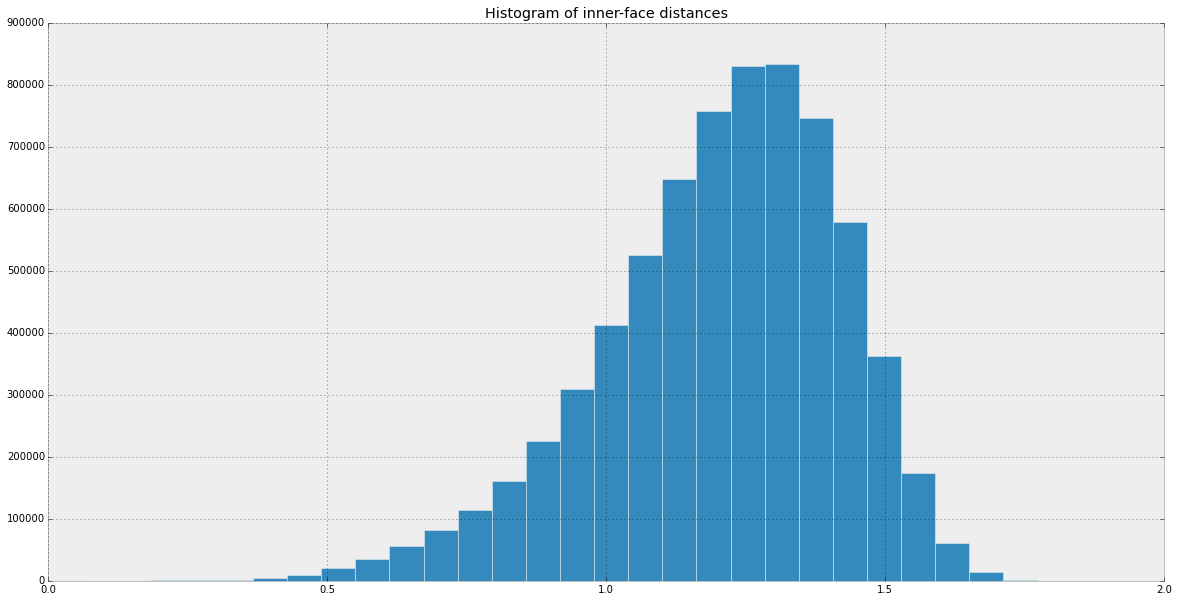

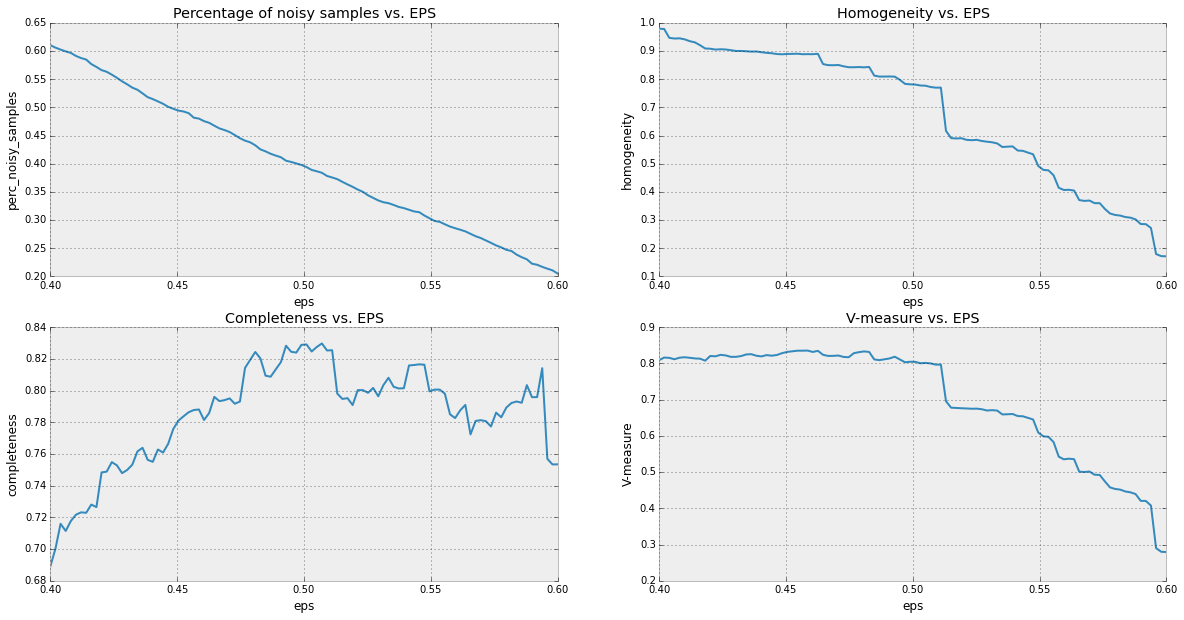

In [192]:
user_id = 8
stats_df = run_dbscan_and_plot(user_id, eps_list=list(np.linspace(0.4,0.6,100)))

In [193]:
stats_df.loc[stats_df['V-measure'].idxmax()]

eps                   0.458586
perc_noisy_samples    0.480043
homogeneity           0.888760
completeness          0.788080
V-measure             0.835397
Name: 29, dtype: float64

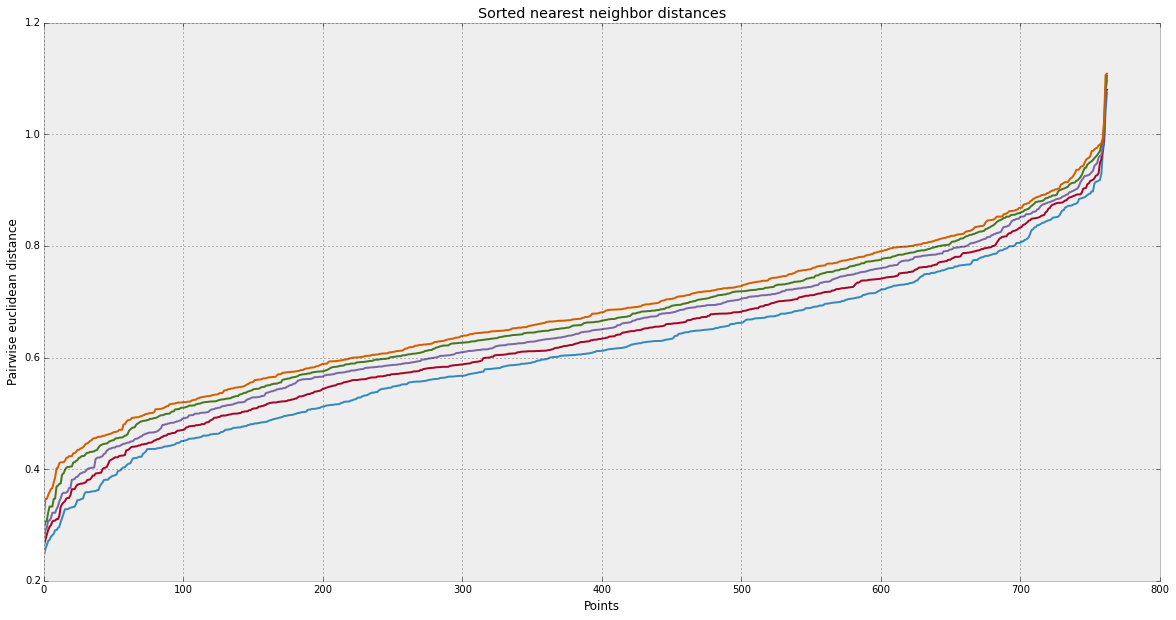

In [191]:
user_id = 2685009
_, X = load_data(user_id)
sorted_k_nearest_dists = plot_k_nearest_dist(X)